In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    InputXGradient,
    Saliency,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz
from model import Net, Net2c
torch.manual_seed(42)
np.random.seed(42)

In [2]:
from acd_wooseok.acd.scores import cd
from acd_wooseok.acd.util import tiling_2d
from acd_wooseok.acd.scores import score_funcs
from torchvision import datasets, transforms
# import modules
from funcs import *
from matfac import *
sys.path.append('../../..')
from hierarchical_dnn_interpretations.acd.scores import cd as acd

# Dataset

In [3]:
# load args
args = dset.get_args()
args.batch_size = int(args.batch_size/2) # half the batchsize
args.epochs = 50
args.cuda = not args.no_cuda and torch.cuda.is_available()

# load mnist dataloader
train_loader, test_loader = dset.load_data_with_indices(args.batch_size, args.test_batch_size, device)

# dataset
X = train_loader.dataset.data.numpy().astype(np.float32)
X = X.reshape(X.shape[0], -1)
X /= 255
Y = train_loader.dataset.targets.numpy()

X_test = test_loader.dataset.data.numpy().astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], -1)
X_test /= 255
Y_test = test_loader.dataset.targets.numpy()

# load NMF object
# run NMF
# nmf = NMF(n_components=30, max_iter=1000)
# nmf.fit(X)
# pkl.dump(nmf, open('./results/nmf_30.pkl', 'wb'))
nmf = pkl.load(open('./results/nmf_30.pkl', 'rb'))
D = nmf.components_
# nmf transform
W = nmf.transform(X) 
W_test = nmf.transform(X_test) 

# Load dataset

In [20]:
baselines_nmf = pkl.load(open('results/baselines_nmf.pkl','rb'))
cd_nmf = pkl.load(open('results/cd_nmf.pkl','rb'))
# store results
results = {}
results['gradient_shap'] = baselines_nmf['gradient_shap']
results['ig'] = baselines_nmf['ig']
results['saliency'] = baselines_nmf['saliency']
results['input_x_gradient'] = baselines_nmf['input_x_gradient']
results['cd'] = cd_nmf['acd']
results['cd_m'] = cd_nmf['cd']
# keys
interp_modules = ['gradient_shap', 'ig', 'saliency', 'input_x_gradient', 'cd', 'cd_m']
# x values
list_of_x = np.arange(30)

## Basis 1

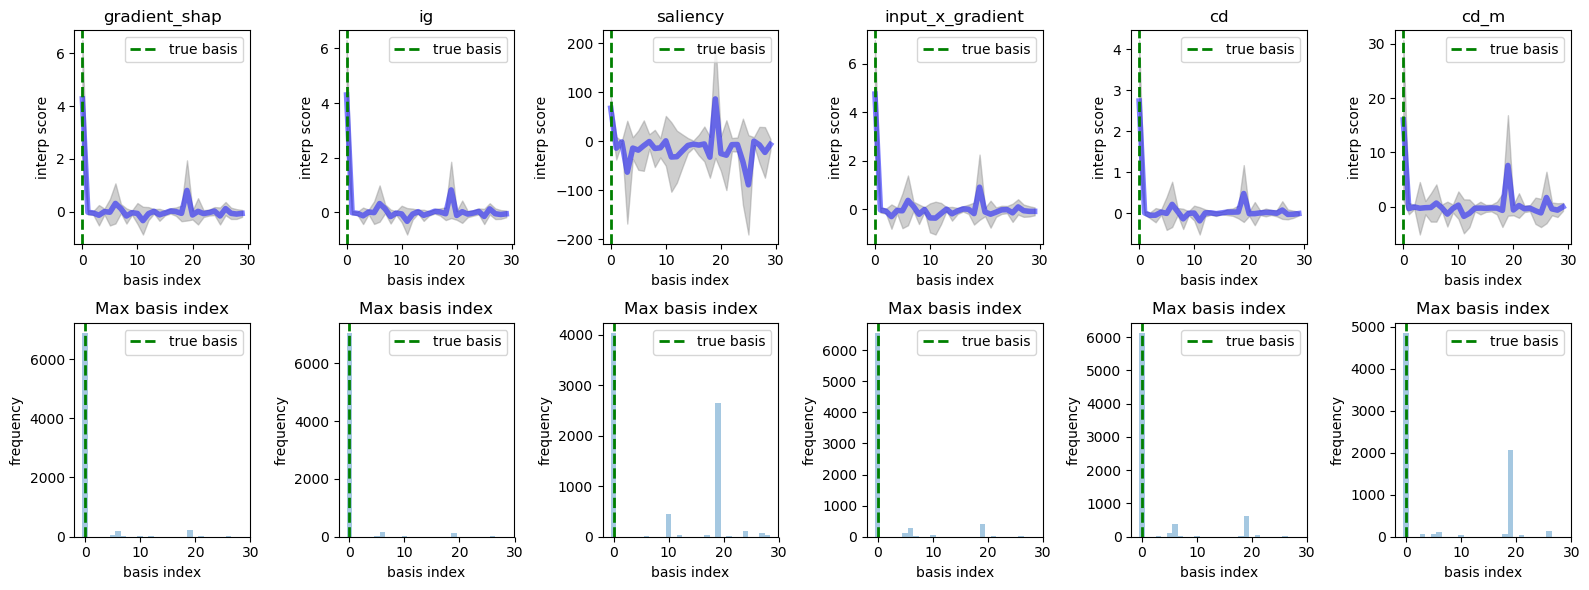

In [36]:
dict_indx = 0

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 2

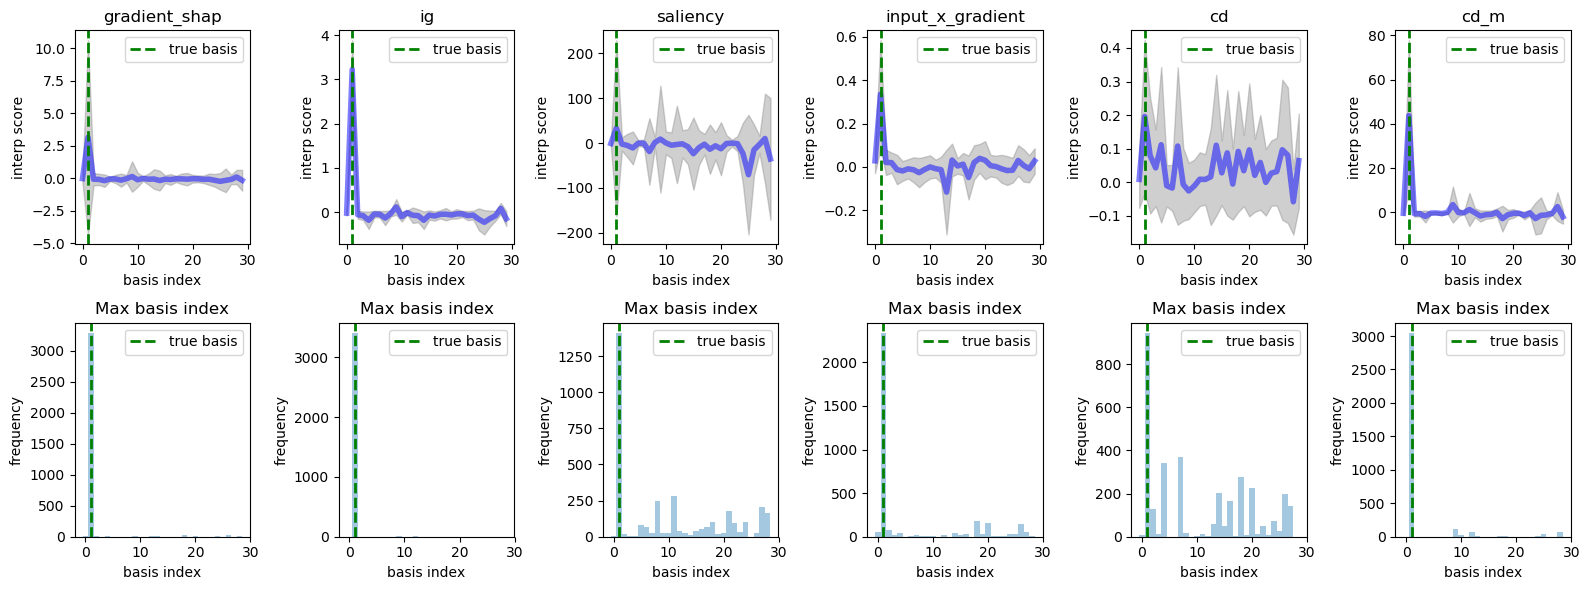

In [37]:
dict_indx = 1

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 3

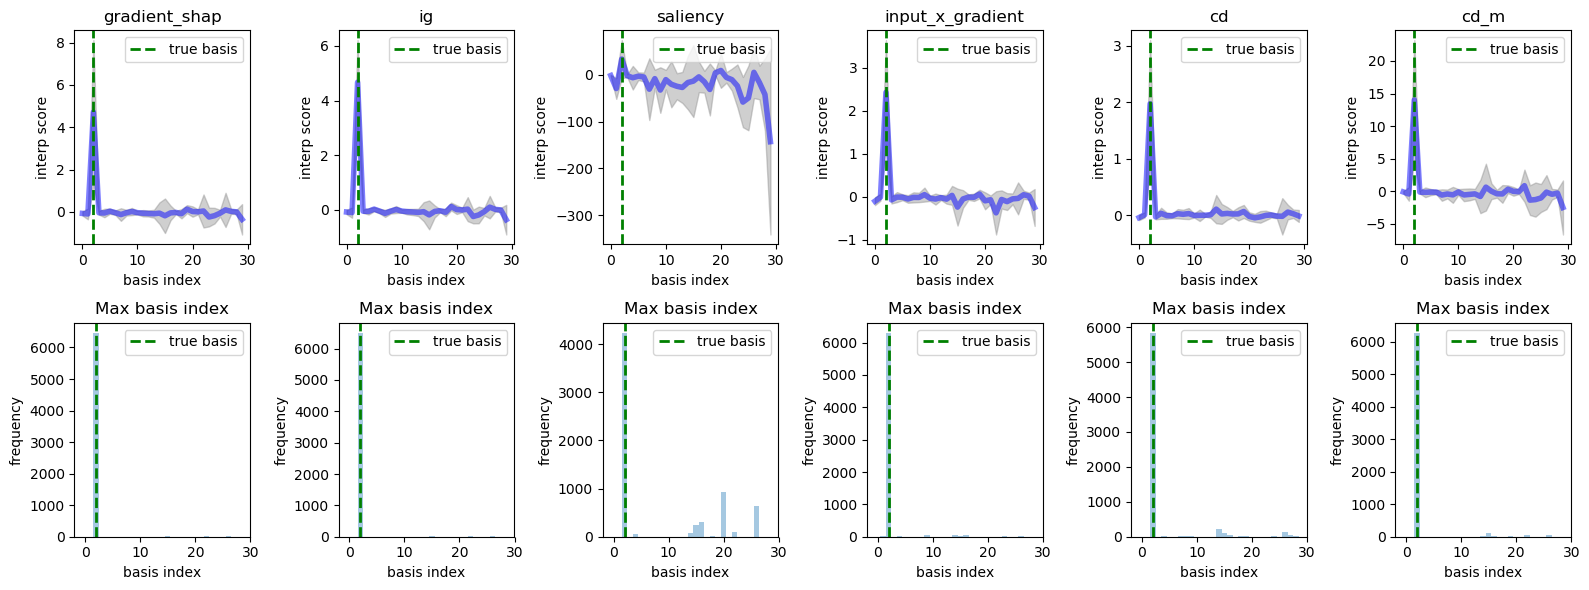

In [38]:
dict_indx = 2

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 4

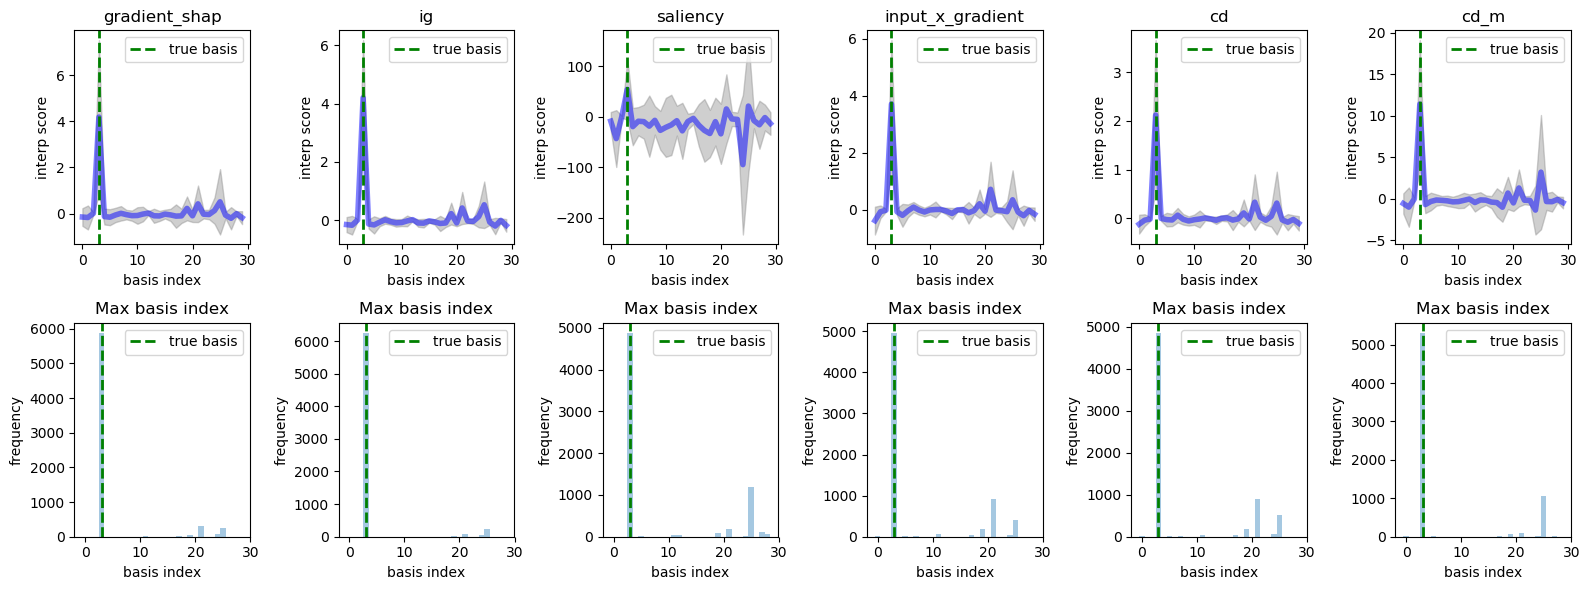

In [39]:
dict_indx = 3

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 5

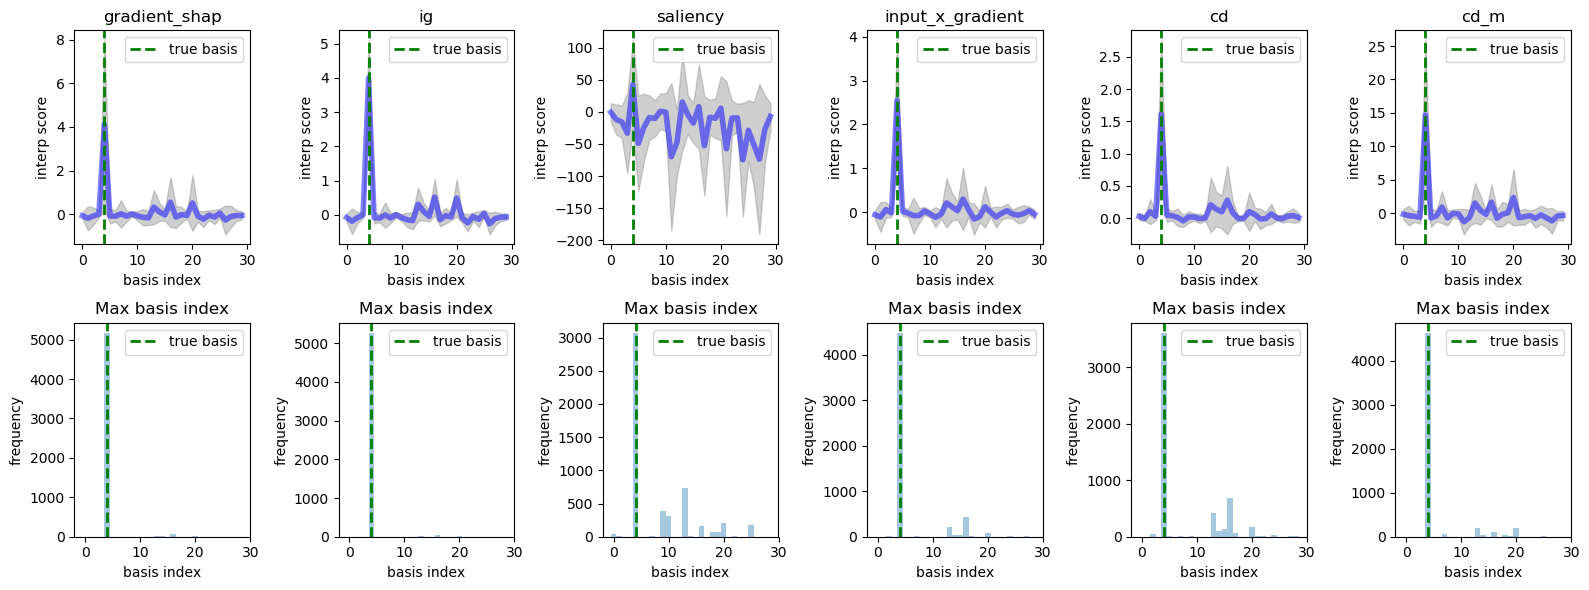

In [40]:
dict_indx = 4

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 6

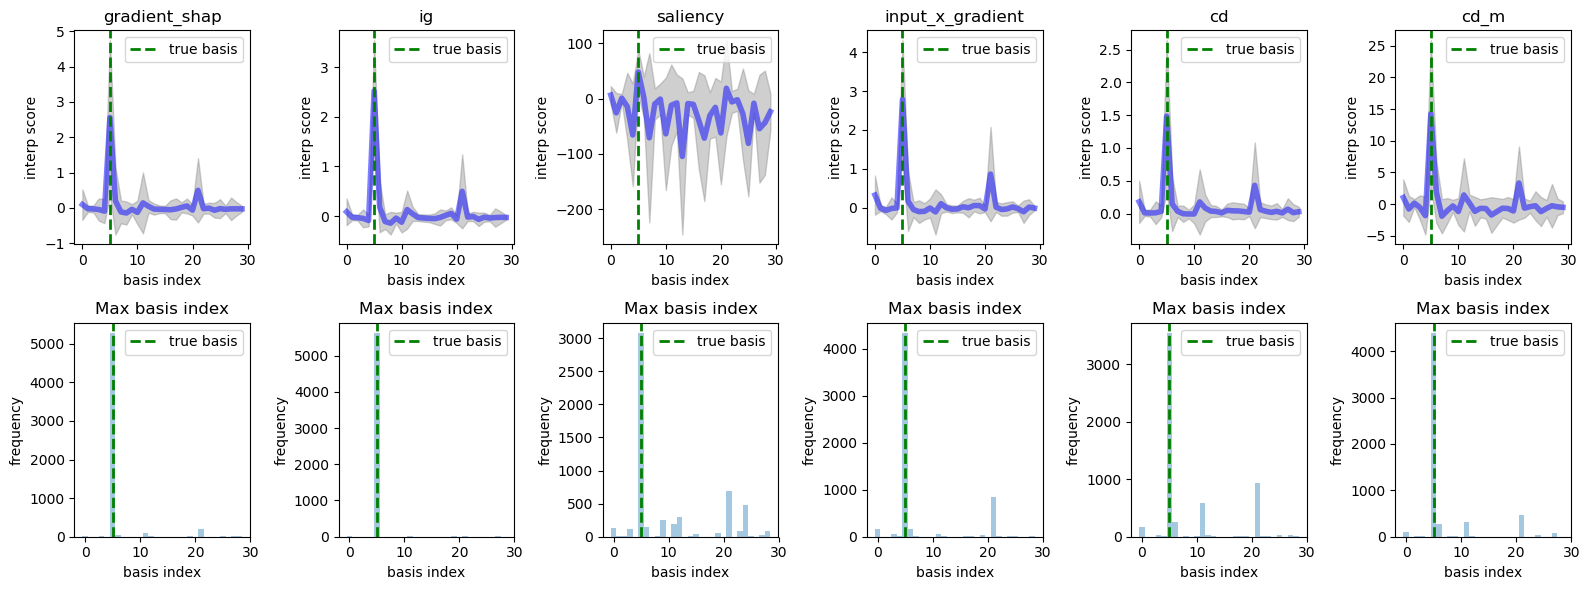

In [41]:
dict_indx = 5

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 7

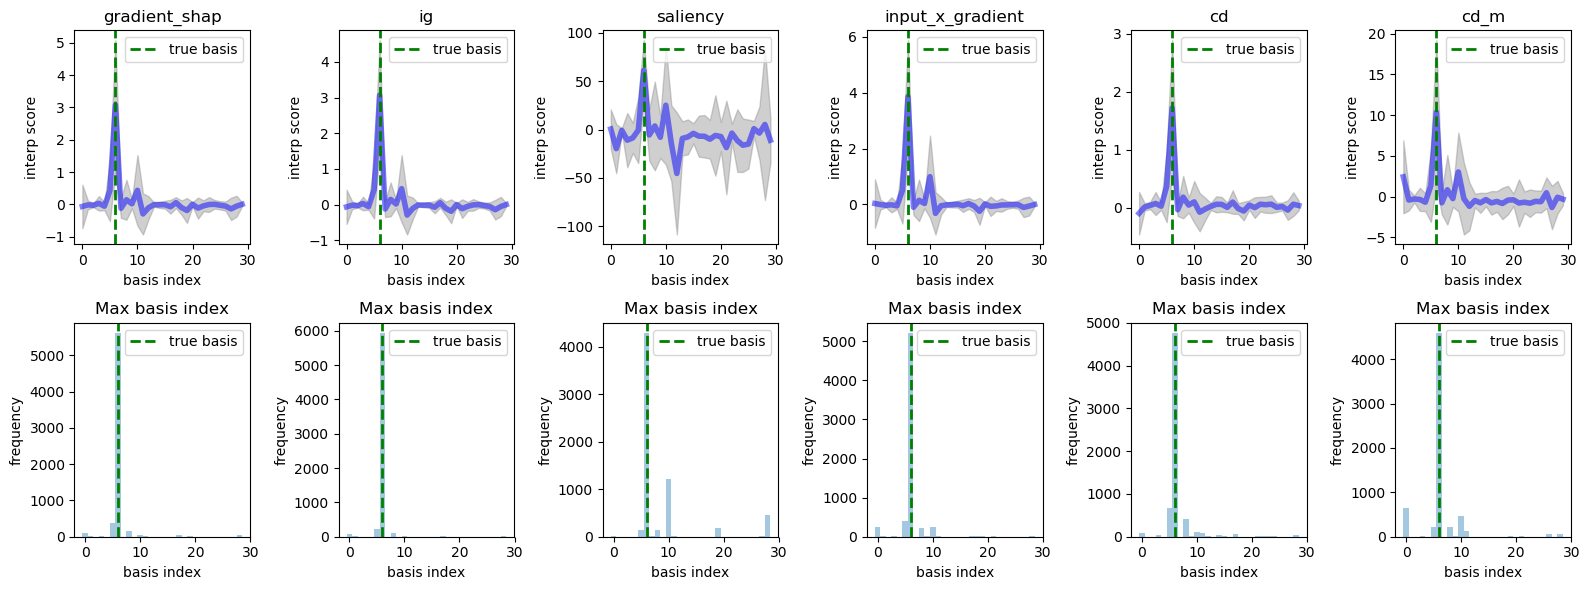

In [42]:
dict_indx = 6

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 8

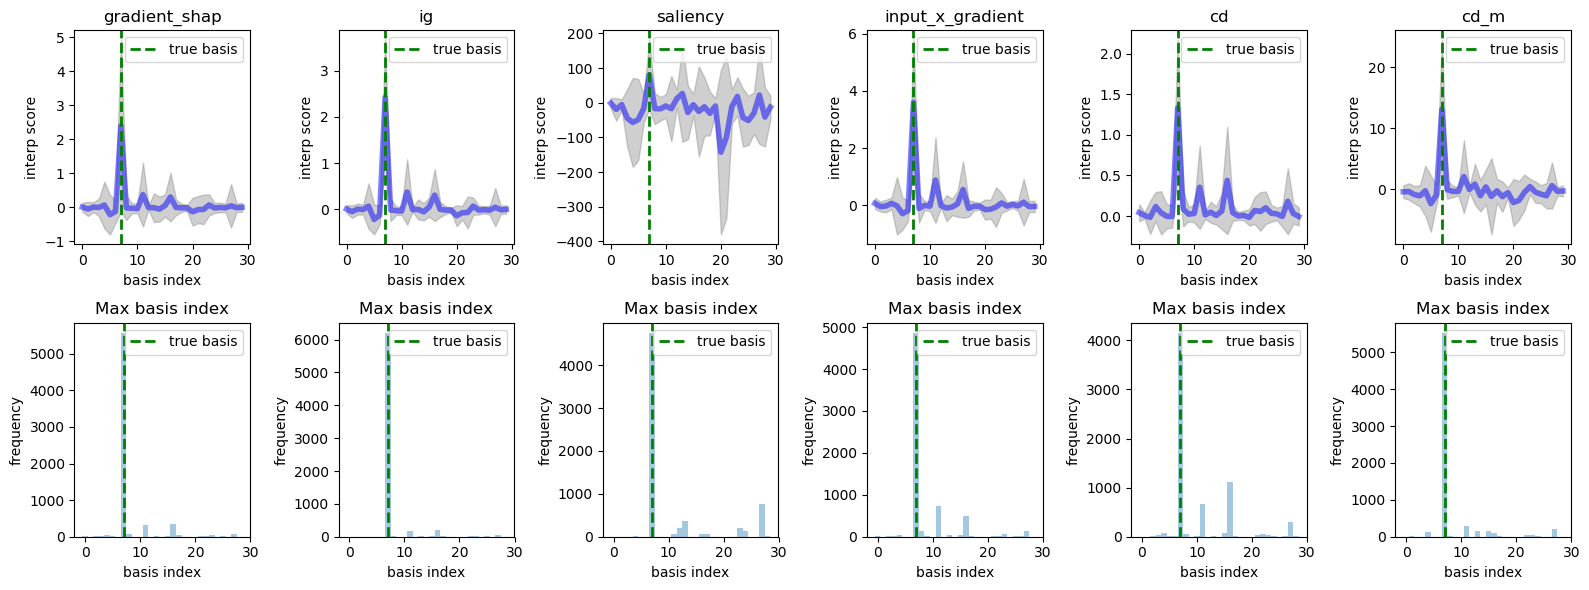

In [43]:
dict_indx = 7

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 9

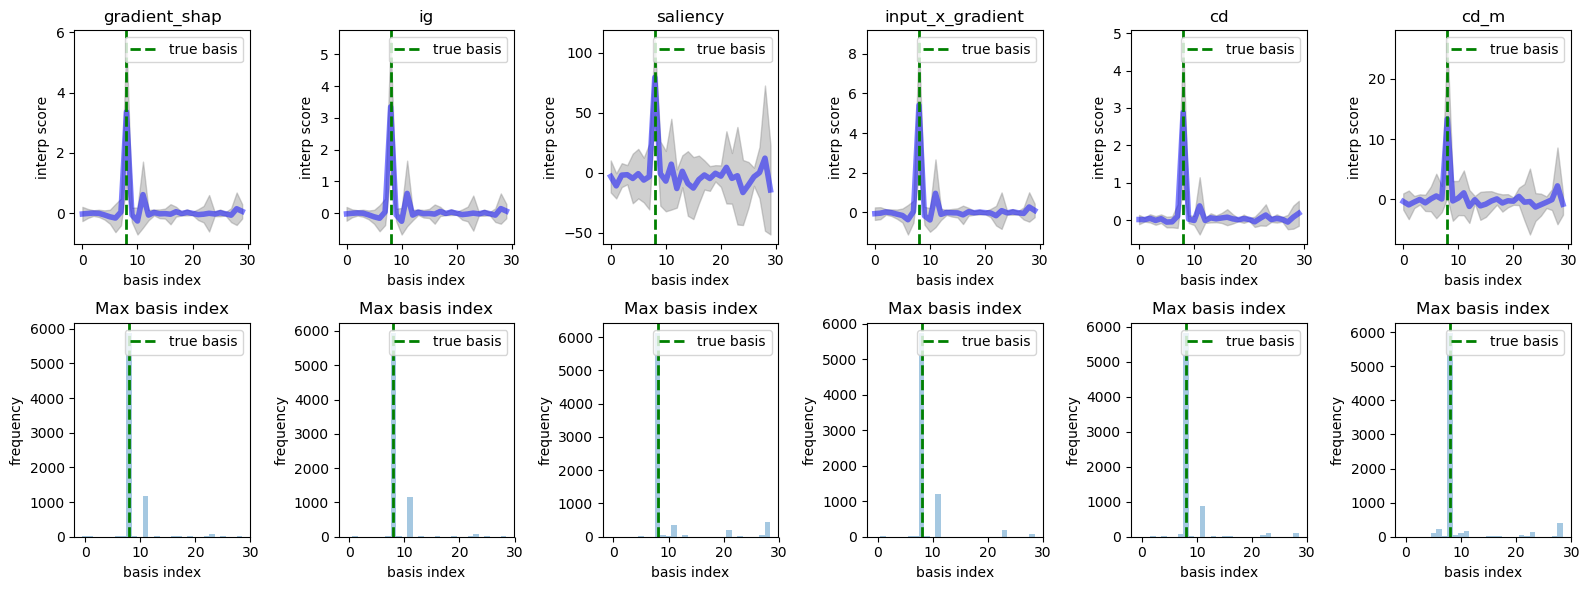

In [44]:
dict_indx = 8

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 10

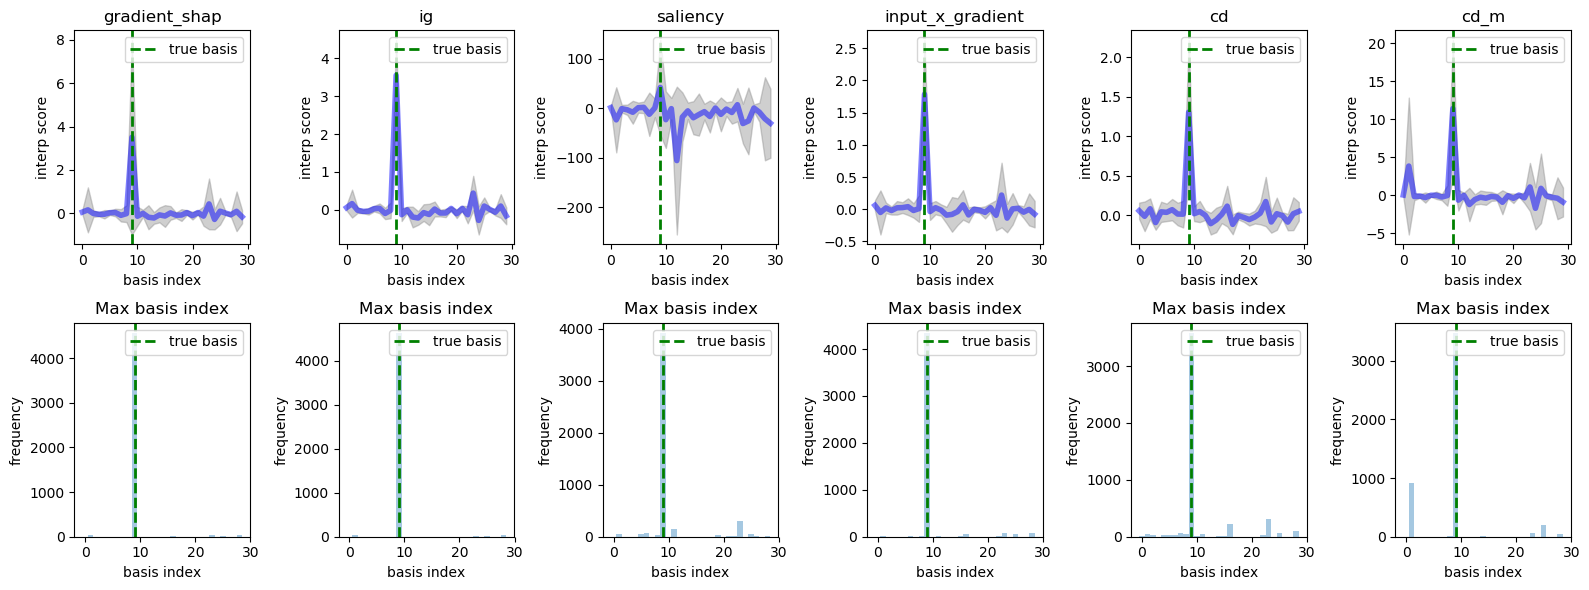

In [46]:
dict_indx = 9

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## Basis 11

IndexError: list index out of range

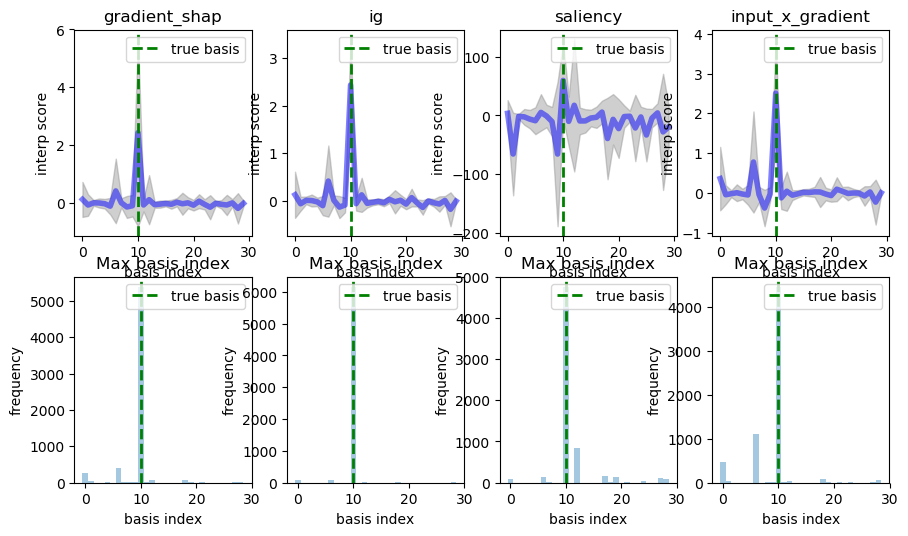

In [47]:
dict_indx = 10

i = 0
plt.figure(figsize=(16, 6),dpi=100)
for c in range(6):
    interp_scores = results[interp_modules[i]][dict_indx]
    plt.subplot(2, 6, i + 1)
    plt.plot(list_of_x, interp_scores.mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, interp_scores.mean(axis=0)-interp_scores.std(axis=0), 
                interp_scores.mean(axis=0)+interp_scores.std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 6, i + 7)
    plt.hist(np.argmax(interp_scores,axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()